In [8]:
from config import DATA_DIR
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

In [2]:
from tensorflow import function, GradientTape, sqrt, abs, reduce_mean, ones_like, zeros_like, convert_to_tensor,float32
from tensorflow import data as tfdata
from tensorflow import config as tfconfig
from tensorflow import nn
from keras import Model, Sequential, Input
from keras.layers import GRU, LSTM, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanSquaredError

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [10]:
df = pd.read_csv(os.path.join(DATA_DIR, "AMZN.csv"))
df = df.set_index('Date').sort_index()

## Parameters

In [11]:
seq_len = 24
n_seq = 6
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 5000

gan_args = batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim

## Proprocess

In [12]:
def preprocess(data, seq_len):
    ori_data = data[::-1]
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)
    
    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)
        
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
        
    return data

In [32]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000
...,...,...,...,...,...,...
2023-07-11,127.750000,129.770004,127.349998,128.779999,128.779999,49951500
2023-07-12,130.309998,131.259995,128.830002,130.800003,130.800003,54022800
2023-07-13,134.039993,134.669998,132.710007,134.300003,134.300003,61170900


In [13]:
stock_data = preprocess(df.values, seq_len)

## Modules

In [14]:
def net(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(GRU(units=hidden_units,
                      return_sequences=True,
                      name=f'GRU_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(LSTM(units=hidden_units,
                      return_sequences=True,
                      name=f'LSTM_{i + 1}'))

    model.add(Dense(units=output_units,
                    activation='sigmoid',
                    name='OUT'))
    return model

In [15]:
class Generator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name='Generator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim,
                    net_type=self.net_type)
        return model

In [16]:
class Discriminator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type

    def build(self, input_shape):
        model = Sequential(name='Discriminator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=1,
                    net_type=self.net_type)
        return model

In [17]:
class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return

    def build(self, input_shape):
        recovery = Sequential(name='Recovery')
        recovery = net(recovery,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.n_seq)
        return recovery

In [18]:
class Embedder(Model):

    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return

    def build(self, input_shape):
        embedder = Sequential(name='Embedder')
        embedder = net(embedder,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.hidden_dim)
        return embedder

In [19]:
class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim

    def build(self, input_shape):
        model = Sequential(name='Supervisor')
        model = net(model,
                    n_layers=2,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim)
        return model

In [20]:
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        self.define_gan()

    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        X = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')

        # AutoEncoder
        H = self.embedder(X)
        X_tilde = self.recovery(H)
        
        self.autoencoder = Model(inputs=X, outputs=X_tilde)

        # Adversarial Supervise Architecture
        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')

        
        # Adversarial architecture in latent space
        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')
        
        #Synthetic data generation
        X_hat = self.recovery(H_hat)
        
        self.generator = Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')

        
        # Final discriminator model
        Y_real = self.discriminator(H)
        
        self.discriminator_model = Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")

        # Loss functions
        self._mse=MeanSquaredError()
        self._bce=BinaryCrossentropy()

## Training Modules

In [21]:
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)
    
    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())

    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))

In [22]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)

## Training

In [23]:
autoencoder_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Emddeding network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)

Emddeding network training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:11<00:00, 19.86it/s]


In [24]:
supervisor_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)

Supervised network training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:21<00:00, 24.83it/s]


In [25]:
generator_opt = Adam(learning_rate=learning_rate)
embedder_opt = Adam(learning_rate=learning_rate)
discriminator_opt = Adam(learning_rate=learning_rate)

In [26]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for _ in tqdm(range(train_steps), desc='Joint networks training'):

    #Train the generator (k times as often as the discriminator)
    # Here k=2
    for _ in range(2):
        X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
        Z_ = next(synth.get_batch_noise())
        
        # Train the generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        # Train the embedder
        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_d_loss = synth.discriminator_loss(X_, Z_)
    
    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)

Joint networks training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:39:51<00:00,  1.20s/it]


In [27]:
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Synthetic data generation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.56it/s]


In [31]:
real_sample

array([[[0.40841577, 0.40903641, 0.41593908, 0.42370208, 0.42370208,
         0.18068738],
        [0.38192812, 0.38937853, 0.39169196, 0.40410312, 0.40410312,
         0.13375385],
        [0.39758571, 0.39835885, 0.39791195, 0.39341102, 0.39341102,
         0.10848195],
        ...,
        [0.34876265, 0.33582443, 0.34628838, 0.34902461, 0.34902461,
         0.14011245],
        [0.32719776, 0.32700566, 0.3351282 , 0.34122038, 0.34122038,
         0.12042905],
        [0.33222037, 0.32393936, 0.32891308, 0.32524905, 0.32524905,
         0.12923924]],

       [[0.25099286, 0.24092453, 0.21874577, 0.24569812, 0.24569812,
         0.28095543],
        [0.26152797, 0.25118374, 0.22897875, 0.24602274, 0.24602274,
         0.25164228],
        [0.23025082, 0.25247677, 0.24040935, 0.24342606, 0.24342606,
         0.21151952],
        ...,
        [0.62948696, 0.62881511, 0.60263864, 0.59694234, 0.59694234,
         0.15830511],
        [0.690976  , 0.69654098, 0.64022869, 0.6346128 , 0.634

In [33]:
synthetic_sample

array([[[0.65596247, 0.6613427 , 0.6552967 , 0.6572883 , 0.66122466,
         0.11928196],
        [0.7300348 , 0.70999134, 0.6958199 , 0.67774355, 0.67765737,
         0.15464851],
        [0.7231719 , 0.7275928 , 0.72578835, 0.73258114, 0.73364425,
         0.10683648],
        ...,
        [0.7243827 , 0.7440913 , 0.7363486 , 0.75412506, 0.7554619 ,
         0.18511997],
        [0.7438923 , 0.74194986, 0.7327349 , 0.73235554, 0.73095757,
         0.21798348],
        [0.74401486, 0.74820584, 0.73660815, 0.7431177 , 0.74130523,
         0.2437767 ]],

       [[0.11092057, 0.12302211, 0.09898674, 0.11844737, 0.11718779,
         0.36484078],
        [0.13967682, 0.12940457, 0.13467425, 0.13059196, 0.13010044,
         0.15091918],
        [0.14720386, 0.14499624, 0.13840844, 0.14286913, 0.14025626,
         0.21179579],
        ...,
        [0.13214856, 0.13296832, 0.12599549, 0.13393997, 0.13383639,
         0.17385706],
        [0.1286361 , 0.13295303, 0.12180121, 0.13339232, 0.132

/var/folders/k4/25t5nv9n58v3dv_qpxrxsbzc0000gn/T/ipykernel_38963/1595968684.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


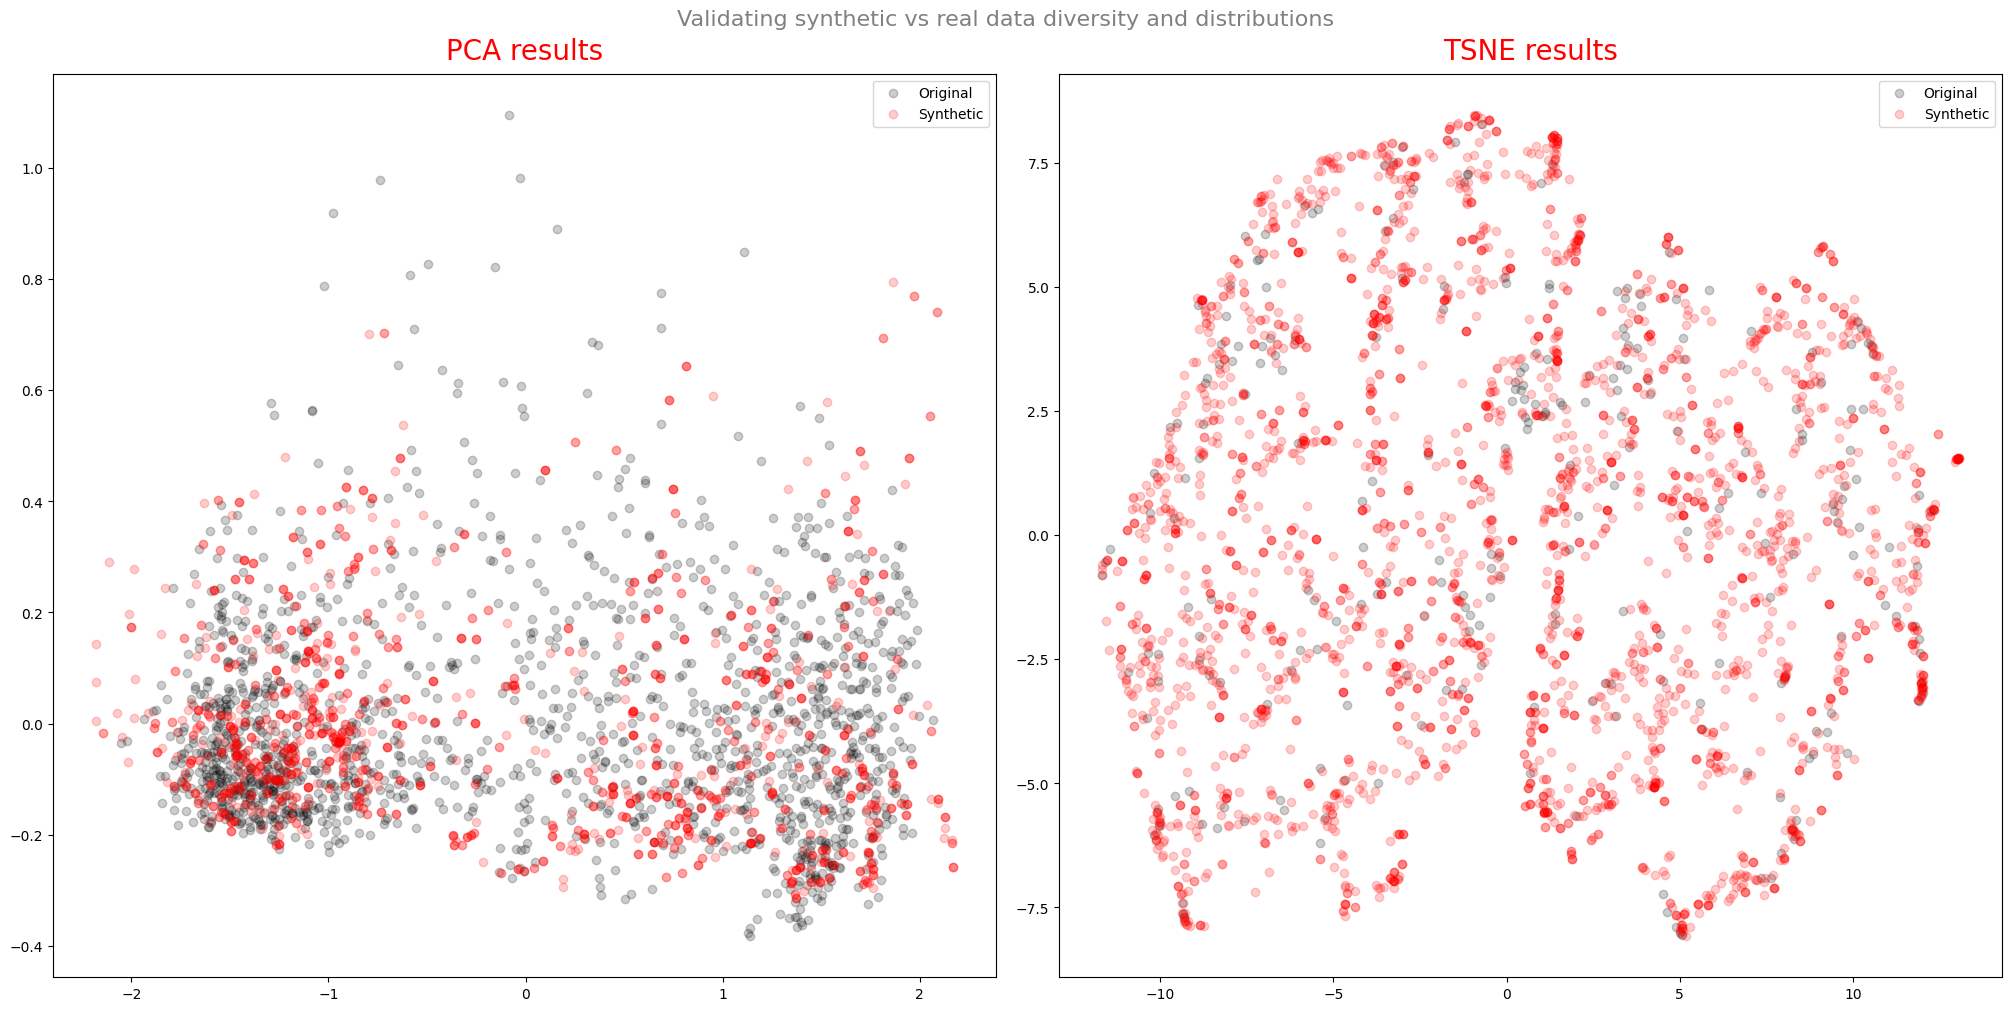

In [30]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')
fig.show()